The purpose of this notebook is to find a set of substrate annotation labels that divide the transporters in *E. coli* into classes which are large enough for training ML models. The labels should have minimal overlap in terms of annotated proteins, and span as much of the genome as possible. Each selected label will have a minimal number of annotated proteins.

We will try to a automate this process with a greedy algorithm removes the annotation with the largest overlap to the rest of the dataset in every step.

There are several sources of substrate annotations:

- ChEBI annotations in TCDB
- ChEBI annotations from EBI
- Gene Ontology Molecular function
- A combination of the above, for example by filtering proteins for transmembrane transport GO terms and then annotating with EBI.

## Dataset

As a first dataset, we will use *E. coli* again. Trying a version of this dataset that is clustered with cd-hit, and a meta-organism dataset, could also be interesting. 

In [1]:
from subpred.util import load_df

df_uniprot = load_df("uniprot")
df_uniprot


,gene_names,protein_names,reviewed,protein_existence,sequence,organism_id
Uniprot,,,,,,
A0A0C5B5G6,MT-RNR1,Mitochondrial-derived peptide MOTS-c (Mitochon...,True,1,MRWQEMGYIFYPRKLR,9606
A0A1B0GTW7,CIROP LMLN2,Ciliated left-right organizer metallopeptidase...,True,1,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,9606
A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Bridge-like lipid transfer protein family memb...,True,1,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606
A0JP26,POTEB3,POTE ankyrin domain family member B3,True,1,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606
A0PK11,CLRN2,Clarin-2,True,1,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606
...,...,...,...,...,...,...
X5L4R4,NOD-2,Nucleotide-binding oligomerization domain-cont...,False,2,MSPGCYKGWPFNCHLSHEEDKRRNETLLQEAETSNLQITASFVSGL...,586796
X5MBL2,GT34D,"Putative galacto(Gluco)mannan alpha-1,6-galact...",False,2,KVLYDRAFNSSDDQSALVYLLLKEKDKWADRIFIEHKYYLNGYWLD...,3352
X5MFI4,GT34D,"Putative galacto(Gluco)mannan alpha-1,6-galact...",False,2,MDEDVLCKGPLHGGSARSLKGSLKRLKRIMESLNDGLIFMGGAVSA...,3352


In [2]:
df_uniprot_ecoli = df_uniprot[df_uniprot.organism_id == 83333].drop(
    "organism_id", axis=1
)
df_uniprot_ecoli


,gene_names,protein_names,reviewed,protein_existence,sequence
Uniprot,,,,,
P00509,aspC b0928 JW0911,Aspartate aminotransferase (AspAT) (EC 2.6.1.1...,True,1,MFENITAAPADPILGLADLFRADERPGKINLGIGVYKDETGKTPVL...
P00803,lepB b2568 JW2552,Signal peptidase I (SPase I) (EC 3.4.21.89) (L...,True,1,MANMFALILVIATLVTGILWCVDKFFFAPKRRERQAAAQAAAGDSL...
P00804,lspA lsp b0027 JW0025,Lipoprotein signal peptidase (EC 3.4.23.36) (P...,True,1,MSQSICSTGLRWLWLVVVVLIIDLGSKYLILQNFALGDTVPLFPSL...
P00861,lysA b2838 JW2806,Diaminopimelate decarboxylase (DAP decarboxyla...,True,1,MPHSLFSTDTDLTAENLLRLPAEFGCPVWVYDAQIIRRQIAALKQF...
P00946,manA pmi b1613 JW1605,Mannose-6-phosphate isomerase (EC 5.3.1.8) (Ph...,True,1,MQKLINSVQNYAWGSKTALTELYGMENPSSQPMAELWMGAHPKSSS...
...,...,...,...,...,...
P76154,ydfK b1544 JW1537,Cold shock protein YdfK,True,2,MKSKDTLKWFPAQLPEVRIILGDAVVEVAKQGRPINTRTLLDYIEG...
P0AEG8,dsrB b1952 JW1936,Protein DsrB,True,2,MKVNDRVTVKTDGGPRRPGVVLAVEEFSEGTMYLVSLEDYPLGIWF...
P33668,ybbC b0498 JW0487,Uncharacterized protein YbbC,True,2,MKYSSIFSMLSFFILFACNETAVYGSDENIIFMRYVEKLHLDKYSV...


Checking for sparse data:

In [3]:
assert not df_uniprot_ecoli.gene_names.isnull().any()
assert not df_uniprot_ecoli.protein_names.isnull().any()
assert not df_uniprot_ecoli.sequence.isnull().any()


What is the distribution among Swissprot and Trembl?

In [4]:
df_uniprot_ecoli[["reviewed", "protein_existence"]].groupby(
    ["reviewed", "protein_existence"]
).apply(len)


reviewed  protein_existence
False     1                       1
          2                       1
True      1                    3118
          2                     164
dtype: int64

In [5]:
df_uniprot_ecoli[~df_uniprot_ecoli.reviewed]


,gene_names,protein_names,reviewed,protein_existence,sequence
Uniprot,,,,,
A0A7H2C7B0,speFL ECK4660 b4803,Leader peptide SpeFL (Arrest peptide SpeFL),False,2,MENNSRTMPHIRRTTHIMKFAHRNSFDFHFFNAR
A0A0A6YVN8,D-tagatose 3-epimerase,D-tagatose 3-epimerase,False,1,MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...


Since Trembl only adds two proteins, we go with Swissprot instead:

In [6]:
df_uniprot_ecoli = df_uniprot_ecoli[df_uniprot_ecoli.reviewed].drop("reviewed", axis=1)


One of the proteins was actually a relatively short peptide. What are the sequence lengths in the dataset, and are there any outliers?

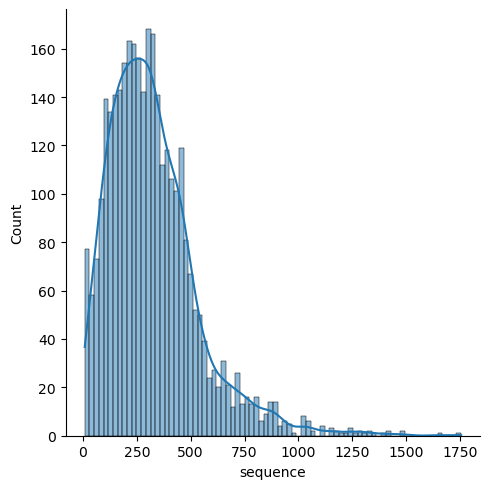

In [7]:
import seaborn as sns

len_sequences = df_uniprot_ecoli.sequence.apply(len)
sns.displot(len_sequences, kde=True, bins=80)


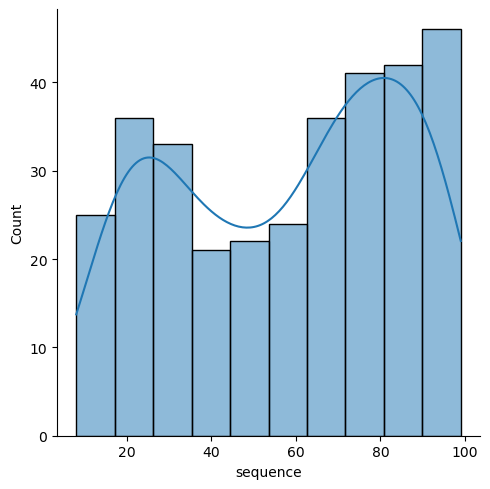

In [8]:
sns.displot(len_sequences[len_sequences < 100], kde=True)


There seems to be an increased number of proteins with sequences with around 20 amino acids. Some of them only have a very small number of amino acids, which would make sequence-based features less reliable. They don't seem to be part of the transporter dataset, but we should still check that dataset for sequence lengths.

In [9]:
df_uniprot_ecoli[df_uniprot_ecoli.sequence.apply(len) < 25]


,gene_names,protein_names,protein_existence,sequence
Uniprot,,,,
C1P617,ibsE b4666 JW3023.2,Small toxic protein IbsE,2,MMKLVIILVVLLLLSFPTY
C1P607,ibsA b4667 JW2058.1,Small toxic protein IbsA,2,MMKHVIILVILLVISFQAY
C1P615,ibsC b4665 JW2879.1,Small toxic protein IbsC,2,MMRLVIILIVLLLISFSAY
C1P603,yoaJ b4675 JW5292.2,Uncharacterized protein YoaJ,1,MKKTTIIMMGVAIIVVLGTELGWW
P0DSH2,baxL b4794,Putative translational regulatory protein BaxL,1,MIKSDQET
C1P610,ypdK b4680 JW2375.1,Uncharacterized membrane protein YpdK,1,MKYFFMGISFMVIVWAGTFALMI
P0AD89,tnaC tnaL b3707 JW3685,Tryptophanase operon leader peptide,1,MNILHICVTSKWFNIDNKIVDHRP
P0AD92,trpL trpEE b1265 JW1257,trp operon leader peptide,1,MKAIFVLKGWWRTS
P0DSG0,pssL b4782,Protein PssL,1,MNREEMHCDVVKI


## Annotations

### GO

In [10]:
df_goa_uniprot = load_df("go")
df_goa_uniprot


,Uniprot,qualifier,go_id,evidence_code,aspect
0,A0A009FND8,enables,GO:0000166,IEA,F
1,A0A009FND8,enables,GO:0005524,IEA,F
2,A0A009FND8,enables,GO:0051082,IEA,F
3,A0A009FND8,enables,GO:0140662,IEA,F
4,A0A009FND8,involved_in,GO:0006457,IEA,P
...,...,...,...,...,...
7452013,Z9JND5,enables,GO:0000166,IEA,F
7452014,Z9JND5,enables,GO:0005524,IEA,F
7452015,Z9JND5,enables,GO:0051082,IEA,F
7452016,Z9JND5,enables,GO:0140662,IEA,F


In [11]:
df_goa_uniprot_ecoli = df_goa_uniprot[
    df_goa_uniprot.Uniprot.isin(df_uniprot_ecoli.index)
]
# df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.assign(
#     evidence_description=df_goa_uniprot_ecoli.evidence_code.map(
#         EVIDENCE_CODE_TO_DESCRIPTION
#     )
# )
df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.reset_index(drop=True)
df_goa_uniprot_ecoli


,Uniprot,qualifier,go_id,evidence_code,aspect
0,A5A615,located_in,GO:0005886,IDA,C
1,A5A615,located_in,GO:0005886,IEA,C
2,A5A615,located_in,GO:0005886,RCA,C
3,A5A615,located_in,GO:0016020,IEA,C
4,A5A616,acts_upstream_of_or_within,GO:0010350,IEP,P
...,...,...,...,...,...
40133,Q93K97,involved_in,GO:0006753,IBA,P
40134,Q93K97,involved_in,GO:0019693,IBA,P
40135,Q93K97,is_active_in,GO:0005829,IBA,C
40136,Q93K97,located_in,GO:0005829,HDA,C


Here, we add the ancestors, now using the OBO file instead of the OWL file, along with a new package.

In [12]:
import obonet
import networkx as nx

graph_go = obonet.read_obo("../data/raw/ontologies/go.obo", ignore_obsolete=True)
# graph_go = obonet.read_obo("../obo_parser/go_2023_01.obo")


In [13]:
id_to_name = {id: data["name"] for id, data in graph_go.nodes(data=True)}
name_to_id = {name: id for id, name in id_to_name.items()}


Are all the terms in the graph?

In [14]:
# check if all go terms are in graph
df_goa_uniprot_ecoli[~df_goa_uniprot_ecoli.go_id.isin(set(graph_go.nodes()))].shape[0]


0

Yes, we don't need to load any deprecated terms.

#### NetworkX Package

https://networkx.org/documentation/stable/reference/classes/multidigraph.html

Interesting functions:

- G.subgraph(nodes)
- G.edge_subgraph(nodes)
- G.edges(keys=True)
- G.nodes(data=True)
- G.predecessors(node)
- G.successors(node)
- nx.has_path(G, source, end)
- nx.is_directed_acyclic_graph(G)
- nx.descendants_at_distance(G, node, d)
- nx.descendants(G, node), higher nodes
- nx.ancestors(G, node): lower nodes
- nx.find_cycle(G) throws exception

Are the edges annotated with the type of relation?

In [15]:
list(graph_go.edges(data=True, keys=True))[:20]


[('GO:0000001', 'GO:0048308', 'is_a', {}),
 ('GO:0000001', 'GO:0048311', 'is_a', {}),
 ('GO:0000002', 'GO:0007005', 'is_a', {}),
 ('GO:0000003', 'GO:0008150', 'is_a', {}),
 ('GO:0000006', 'GO:0005385', 'is_a', {}),
 ('GO:0000007', 'GO:0005385', 'is_a', {}),
 ('GO:0000009', 'GO:0000030', 'is_a', {}),
 ('GO:0000010', 'GO:0004659', 'is_a', {}),
 ('GO:0000011', 'GO:0007033', 'is_a', {}),
 ('GO:0000011', 'GO:0048308', 'is_a', {}),
 ('GO:0000012', 'GO:0006281', 'is_a', {}),
 ('GO:0000014', 'GO:0004520', 'is_a', {}),
 ('GO:0000015', 'GO:1902494', 'is_a', {}),
 ('GO:0000015', 'GO:0005829', 'part_of', {}),
 ('GO:0000016', 'GO:0004553', 'is_a', {}),
 ('GO:0000017', 'GO:0042946', 'is_a', {}),
 ('GO:0000018', 'GO:0051052', 'is_a', {}),
 ('GO:0000018', 'GO:0006310', 'regulates', {}),
 ('GO:0000019', 'GO:0000018', 'is_a', {}),
 ('GO:0000019', 'GO:0006312', 'regulates', {})]

Yes, does this mean that the ancestors of a MF term also include BP?

In [16]:
print(
    "path from transmembrane transporter activity to biological process?",
    nx.has_path(graph_go, "GO:0022857", "GO:0008150"),
)
print(
    "path from transmembrane transporter activity to molecular function?",
    nx.has_path(graph_go, "GO:0022857", "GO:0003674"),
)
print(
    "path from transmembrane transporter activity to cellular component?",
    nx.has_path(graph_go, "GO:0022857", "GO:0005575"),
)


path from transmembrane transporter activity to biological process? True
path from transmembrane transporter activity to molecular function? True
path from transmembrane transporter activity to cellular component? False


Yes, that is the case. If we want the direct ancestors of a term in the same ontology (e.g. MF), we have to filter the graph for MF nodes first.

Are all three namespaces in the file?

In [17]:
{data["namespace"] for _, data in graph_go.nodes(data=True)}


{'biological_process', 'cellular_component', 'molecular_function'}

Creating subgraph that only contains MF nodes:

In [18]:
# graph_go_mf
nodes_mf = [
    node
    for node, data in graph_go.nodes(data=True)
    if data["namespace"] == "molecular_function"
]
graph_go_mf = graph_go.subgraph(nodes=nodes_mf)


Did it work? Are there BP terms related to transmembrane transporter activity?

In [19]:
# TODO delete cycles, then bfs?
# TODO remove leaves?


tmtp_ancestors = nx.ancestors(
    graph_go_mf, name_to_id["transmembrane transporter activity"]
)
tmtp_descendants = nx.descendants(
    graph_go_mf, name_to_id["transmembrane transporter activity"]
)

{
    data["namespace"]
    for _, data in graph_go_mf.subgraph(tmtp_ancestors | tmtp_descendants).nodes(
        data=True
    )
}


{'molecular_function'}

Does the set of ancestor/descendants nodes contain the node itself? This was the case in owlready2.

In [20]:
print(
    "source in ancestors:",
    name_to_id["transmembrane transporter activity"] in tmtp_ancestors,
)
print(
    "source in descendants:",
    name_to_id["transmembrane transporter activity"] in tmtp_descendants,
)


source in ancestors: False
source in descendants: False


Is the graph acyclic? Cycles can cause problems when traversing the graph. 

https://networkx.org/documentation/stable/reference/algorithms/cycles.html

In [21]:
print("entire go acyclic?", nx.is_directed_acyclic_graph(graph_go))
print("go-mf acyclic?", nx.is_directed_acyclic_graph(graph_go_mf))


entire go acyclic? False
go-mf acyclic? False


Creating a subgraph for just transmembrane transporters:

What if we only look at the transmembrane transporter annotations? 

The subgraph should also contain "transmembrane transporter activity" as its root node, otherwise there would be multiple connected components.


In [22]:
graph_go_mf_tmtp = graph_go_mf.subgraph(
    tmtp_ancestors | {name_to_id["transmembrane transporter activity"]}
)
print("transporter subgraph acyclic?", nx.is_directed_acyclic_graph(graph_go_mf_tmtp))


transporter subgraph acyclic? True


We should also look at the edge annotations, i.e. the types of relations in the subgraph:

In [23]:
from collections import Counter

Counter([edge[2] for edge in list(graph_go_mf_tmtp.edges(keys=True))])


Counter({'is_a': 1885, 'part_of': 1})

Only one of the edges that are left does not use the is_a relation. Which one is that?

In [24]:
source, target, relation = [
    edge for edge in list(graph_go_mf_tmtp.edges(keys=True)) if edge[2] == "part_of"
][0]
id_to_name[source], relation, id_to_name[target]


('gap junction hemi-channel activity',
 'part_of',
 'gap junction channel activity')

That looks okay.

####  Annotating the graph with E. Coli data:

Now we will add the number of proteins annotated with a particular annotation in E Coli

In [25]:
from copy import deepcopy

graph_go_mf_tmtp_ecoli = deepcopy(graph_go_mf_tmtp.copy())


Filtering: Removing the small number of less accurate annotations (qualifier != enables), filtering for go terms from the transmembrane transporter subgraph.

In [26]:
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli[
    df_goa_uniprot_ecoli.go_id.isin(set(graph_go_mf_tmtp_ecoli.nodes()))
]
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp[
    df_goa_uniprot_ecoli_tmtp.qualifier == "enables"
].drop("qualifier", axis=1)
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp.drop("aspect", axis=1)
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp.reset_index(drop=True)
df_goa_uniprot_ecoli_tmtp


,Uniprot,go_id,evidence_code
0,A5A627,GO:0005253,IDA
1,A5A627,GO:0005253,IEA
2,P00393,GO:0008137,IDA
3,P00550,GO:0008982,IEA
4,P00550,GO:0022872,IEA
...,...,...,...
1397,Q59385,GO:0015662,IDA
1398,Q59385,GO:0019829,IEA
1399,Q59385,GO:0043682,IBA
1400,Q59385,GO:0140581,IEA


We will keep the IEA terms for now:

In [27]:
# Adding ancestor terms, as well as the term itself. Using the tmtp graph, so that all ancestors are descendants of tmtp.
df_goa_uniprot_ecoli_tmtp["ancestors"] = [
    nx.descendants(graph_go_mf_tmtp_ecoli, go_id) | {go_id}
    for go_id in df_goa_uniprot_ecoli_tmtp.go_id
]
df_goa_uniprot_ecoli_tmtp = (
    df_goa_uniprot_ecoli_tmtp.explode("ancestors")
    .drop("go_id", axis=1)
    .rename(columns={"ancestors": "go_id"})
    .drop_duplicates()
    .reset_index(drop=True)
)
df_goa_uniprot_ecoli_tmtp


,Uniprot,evidence_code,go_id
0,A5A627,IDA,GO:0008509
1,A5A627,IDA,GO:0022803
2,A5A627,IDA,GO:0015267
3,A5A627,IDA,GO:0005216
4,A5A627,IDA,GO:0022857
...,...,...,...
7235,Q6BEX0,IEA,GO:0015144
7236,Q6BEX0,IEA,GO:0043211
7237,Q6BEX0,IEA,GO:0015145
7238,Q6BEX0,IEA,GO:0015149


We will keep the IEA terms for now, and maybe create a comparison later:

<AxesSubplot:>

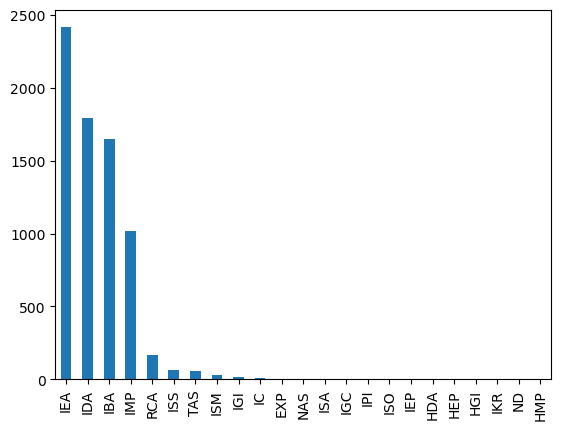

In [28]:
df_goa_uniprot_ecoli_tmtp.evidence_code.value_counts().plot.bar()


In [29]:
df_goa_uniprot_ecoli_tmtp


,Uniprot,evidence_code,go_id
0,A5A627,IDA,GO:0008509
1,A5A627,IDA,GO:0022803
2,A5A627,IDA,GO:0015267
3,A5A627,IDA,GO:0005216
4,A5A627,IDA,GO:0022857
...,...,...,...
7235,Q6BEX0,IEA,GO:0015144
7236,Q6BEX0,IEA,GO:0043211
7237,Q6BEX0,IEA,GO:0015145
7238,Q6BEX0,IEA,GO:0015149


Map of GO term to number of annotations in E Coli, once with IEA and once without:

In [30]:
annotations_to_go_term_ecoli_with_iea = (
    df_goa_uniprot_ecoli_tmtp[["Uniprot", "go_id"]]
    .drop_duplicates()
    .groupby("go_id")
    .apply(len)
    .to_dict()
)
len(annotations_to_go_term_ecoli_with_iea)


386

In [31]:
annotations_to_go_term_ecoli_no_iea = (
    df_goa_uniprot_ecoli_tmtp[df_goa_uniprot_ecoli_tmtp.evidence_code != "IEA"][
        ["Uniprot", "go_id"]
    ]
    .drop_duplicates()
    .groupby("go_id")
    .apply(len)
    .to_dict()
)
len(annotations_to_go_term_ecoli_no_iea)


348

Adding the counts to the node data in the graph:

In [32]:
graph_go_mf_tmtp_ecoli = graph_go_mf_tmtp_ecoli.subgraph(
    annotations_to_go_term_ecoli_with_iea.keys()
)
for go_term, count in annotations_to_go_term_ecoli_with_iea.items():
    graph_go_mf_tmtp_ecoli.nodes[go_term]["ecoli_count_iea"] = count
    if go_term in annotations_to_go_term_ecoli_no_iea.keys():
        count_noiea = annotations_to_go_term_ecoli_no_iea[go_term]
    else:
        count_noiea = 0
    graph_go_mf_tmtp_ecoli.nodes[go_term]["ecoli_count_noiea"] = count_noiea
# for go_term, count in annotations_to_go_term_ecoli_no_iea.items():
#     graph_go_mf_tmtp_ecoli.nodes[go_term]["ecoli_count_noiea"] = count


Calculating overlap edges. Only for nodes that do not share a path. 

In [33]:
name_to_id["solute:proton symporter activity"]

'GO:0015295'

In [34]:
def get_overlap_edges(go_df, graph):
    edges_overlap = list()
    go_term_to_protein_set_iea = go_df.drop("evidence_code", axis=1).groupby("go_id").apply(lambda x: set(x.Uniprot.tolist())).to_dict()
    tmp = list(go_term_to_protein_set_iea.keys())
    for i in range(len(tmp)):
        for j in range(i+1, len(tmp)):
            go_1 = tmp[i]
            go_2 = tmp[j]
            overlap = len(go_term_to_protein_set_iea[go_1] & go_term_to_protein_set_iea[go_2])
            has_path = nx.has_path(graph, go_1, go_2) or nx.has_path(graph, go_2, go_1)
            if overlap > 0 and not has_path:
                edges_overlap.append((go_1, go_2, overlap))    

    return edges_overlap

In [35]:
edges_overlap_iea = get_overlap_edges(df_goa_uniprot_ecoli_tmtp, graph_go_mf_tmtp_ecoli)
edges_overlap_noiea = get_overlap_edges(df_goa_uniprot_ecoli_tmtp[df_goa_uniprot_ecoli_tmtp.evidence_code != "IEA"], graph_go_mf_tmtp_ecoli)

Adding them as edges:

## Plot

https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

In [36]:
import matplotlib.pyplot as plt


def graph_plot(
    graph_to_plot,
    label_name: str = "name",
    label_count: str = None,
    title: str = "",
    rotation: int = 20,
    size: tuple = (30, 30),
    overlap_edges: list = None,
    min_overlap: int = 20,
    graphviz_layout:str="dot",
    node_size=1000
):
    graph_to_plot = graph_to_plot.copy()

    plt.figure(3, figsize=size)

    # progs: ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
    layout = nx.nx_agraph.graphviz_layout(
        graph_to_plot, prog=graphviz_layout, root=name_to_id["transmembrane transporter activity"]
    )

    nx.draw(graph_to_plot, layout, node_size=node_size, node_color="white")

    labels_name_dict = dict(graph_to_plot.nodes(data=label_name))
    text = nx.draw_networkx_labels(
        graph_to_plot, pos=layout, labels=labels_name_dict, verticalalignment="bottom"
    )
    for _, t in text.items():
        t.set_rotation(rotation)
        t.set_rotation_mode("anchor")

    if label_count:
        labels_count_dict = dict(graph_to_plot.nodes(data=label_count))
        text = nx.draw_networkx_labels(
            graph_to_plot, pos=layout, labels=labels_count_dict, verticalalignment="top"
        )
        for _, t in text.items():
            t.set_rotation(rotation)
            t.set_rotation_mode("anchor")

    if overlap_edges:
        nodes_set = set(graph_to_plot.nodes())
        overlap_edges = [
            edge
            for edge in overlap_edges
            if (
                edge[0] in nodes_set and edge[1] in nodes_set and edge[2] >= min_overlap
            )
        ]
        graph_to_plot.add_weighted_edges_from(overlap_edges)
        nx.draw_networkx_edges(
            graph_to_plot,
            layout,
            edgelist=overlap_edges,
            alpha=0.2,
            style="dashed",
            arrows=False,
            edge_color="red",
            # connectionstyle="arc3,rad=0.05"
        )
        nx.draw_networkx_edge_labels(
            graph_to_plot,
            layout,
            edge_labels={(edge[0], edge[1]): edge[2] for edge in overlap_edges},
            font_color="red",
            alpha=0.2,
        )
    plt.title(title)
    plt.show()


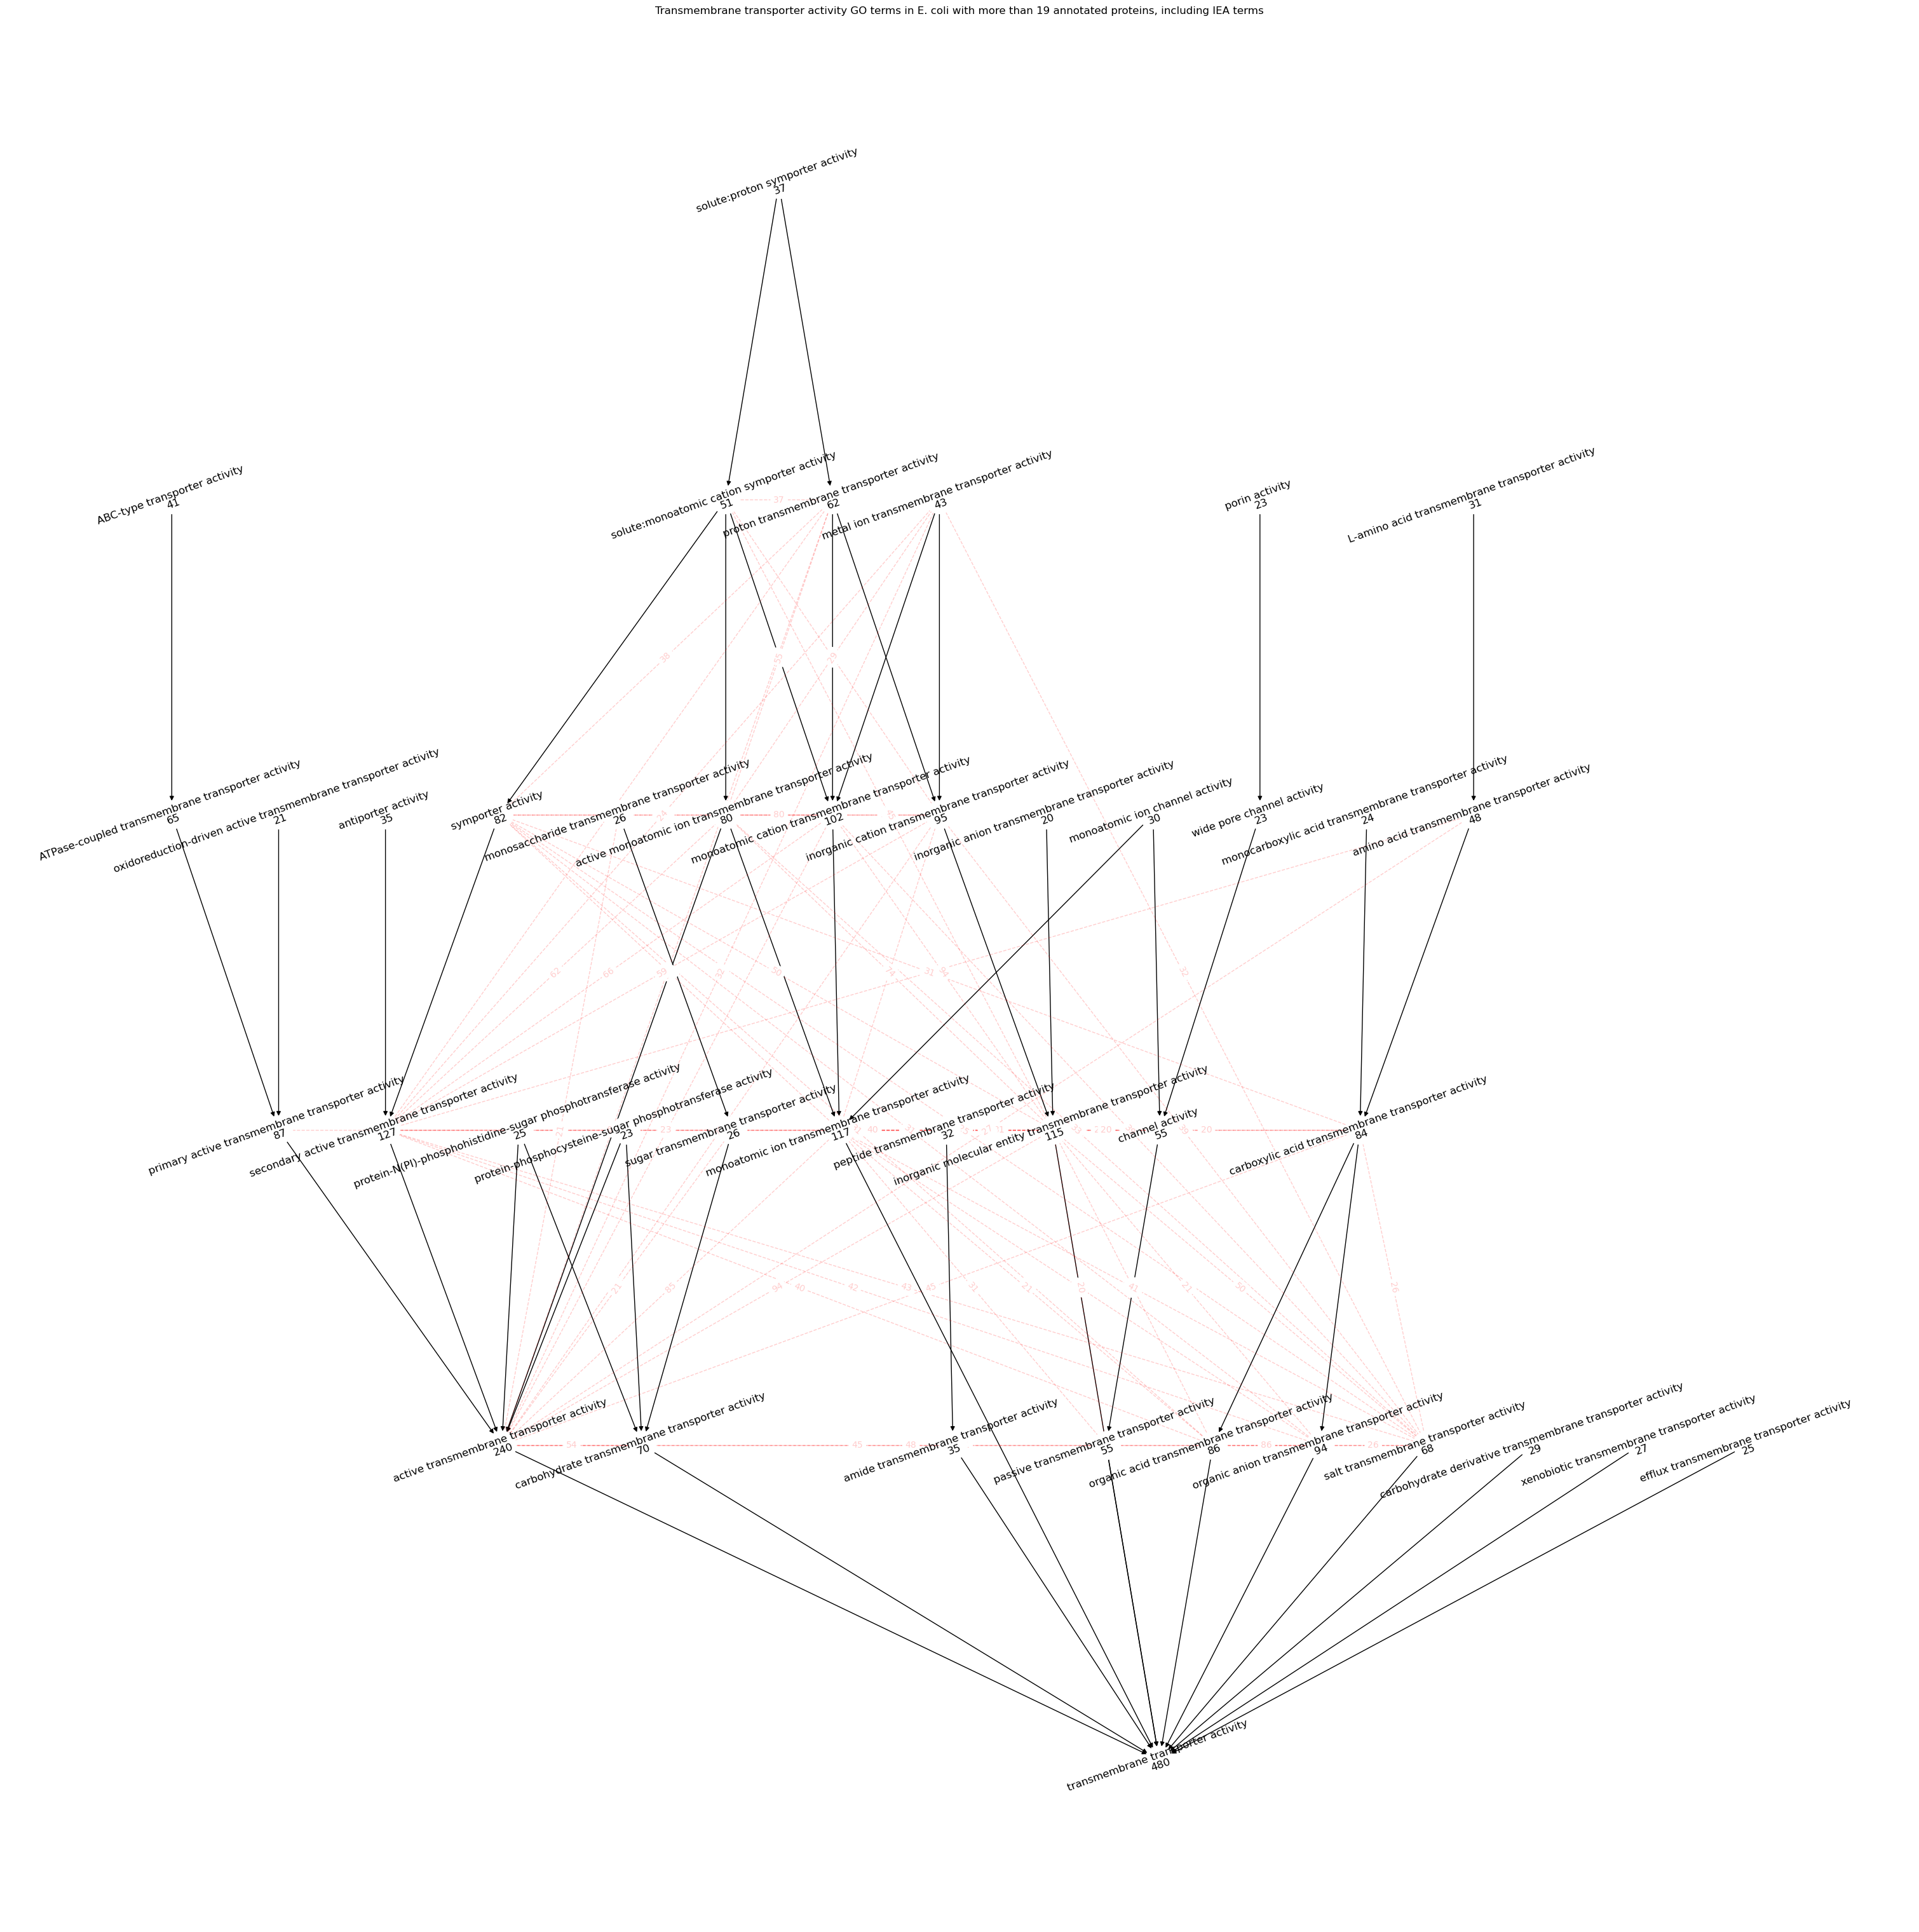

In [37]:
graph_plot(
    graph_to_plot=graph_go_mf_tmtp_ecoli.subgraph(
        {
            go_id
            for go_id, count in graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count_iea")
            if count >= 20
        }
    ),
    label_name="name",
    label_count="ecoli_count_iea",
    title="Transmembrane transporter activity GO terms in E. coli with more than 19 annotated proteins, including IEA terms",
    overlap_edges=edges_overlap_iea,
    min_overlap=20,
    rotation=20,
    # progs: ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
    graphviz_layout="dot"
)

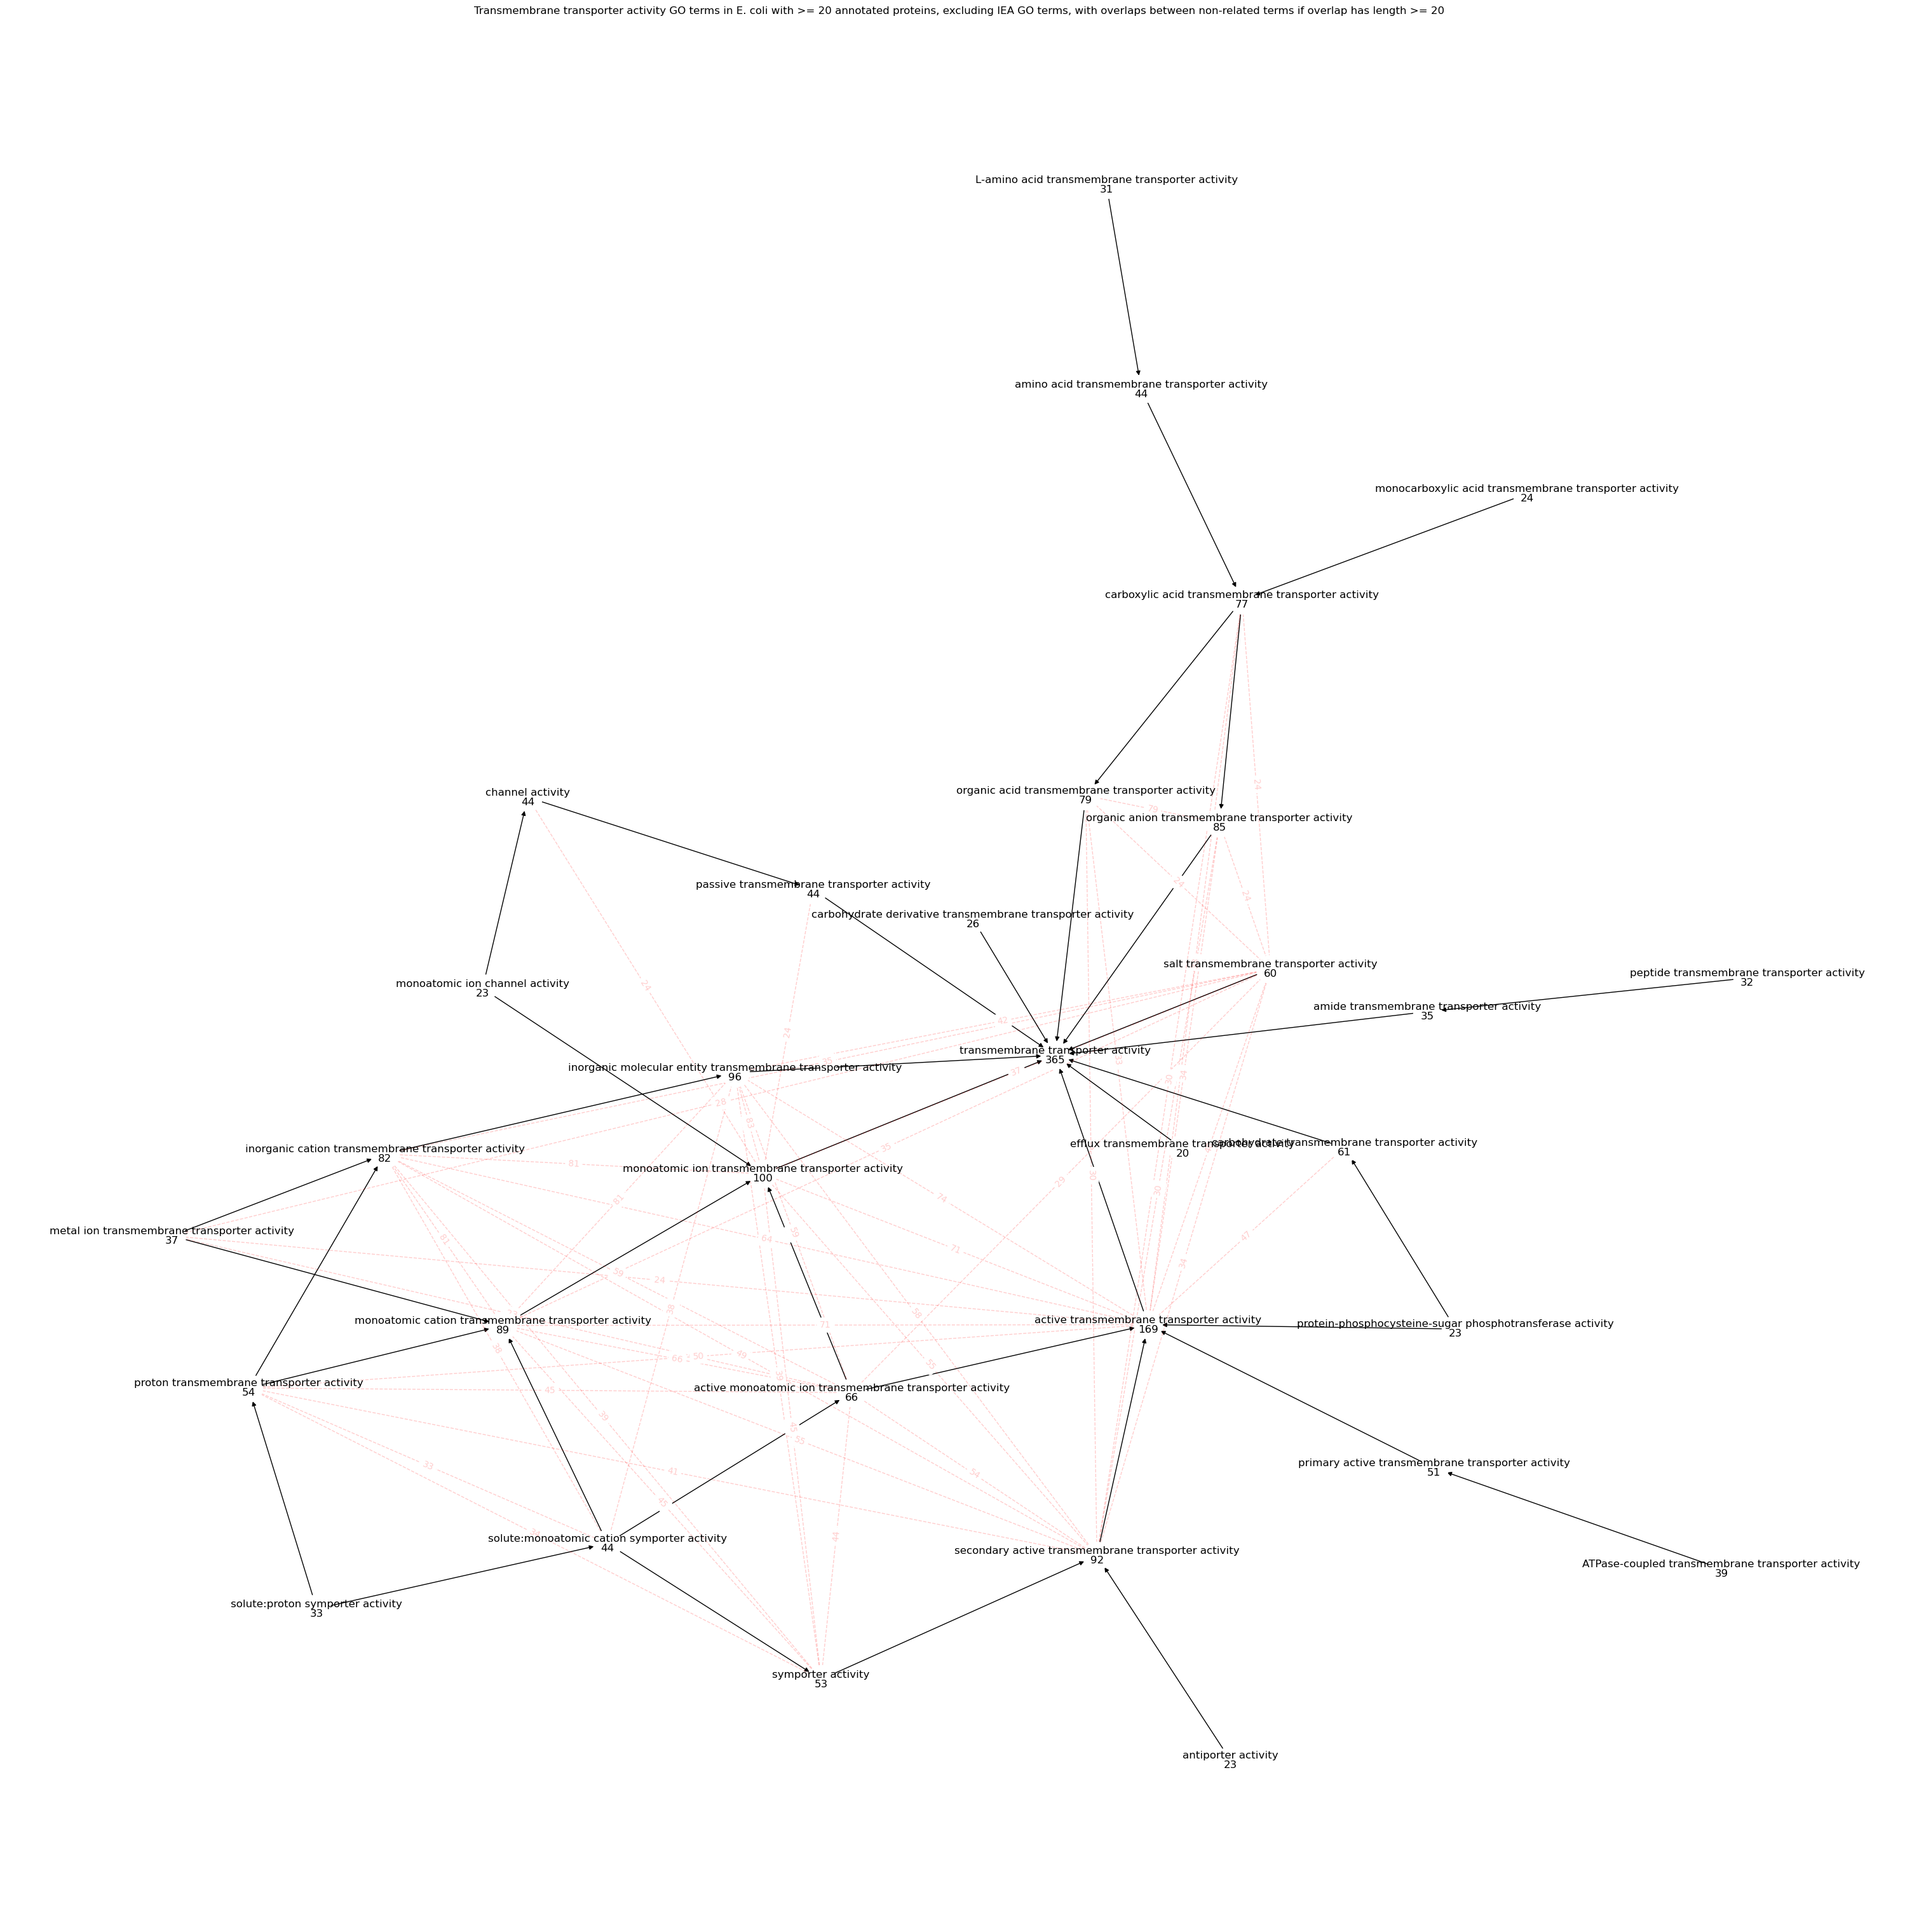

In [38]:
graph_plot(
    graph_to_plot=graph_go_mf_tmtp_ecoli.subgraph(
        {
            go_id
            for go_id, count in graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count_noiea")
            if count >= 20
        }
    ),
    label_name="name",
    label_count="ecoli_count_noiea",
    title="Transmembrane transporter activity GO terms in E. coli with >= 20 annotated proteins, \
excluding IEA GO terms, with overlaps between non-related terms if overlap has length >= 20",
    overlap_edges=edges_overlap_noiea,
    min_overlap=20,
    rotation=0,
    # progs: ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
    graphviz_layout="neato",
    node_size=1000
)


## Chebi

When looking through datasets, it looked like there is a link between chebi and go. Where can I get this data?

Options:

- Chebi OBO file
- GO OBO file
- Mapping files

I could look at go terms with a specific substrate, and see if it is annotated.

#### GO files

Does not work:

- The OBO file contains some xrefs, but not for amino acid transmembrane transporter activity
- go-plus.owl: Not available as obo, but contains xrefs. did not contain amino acid transmembrane transporter activity xref to chebi!
- AmiGO2 also does not contain xref to Chebi
- All mappings to other resources are available at http://geneontology.org/docs/download-mappings/ , but nothing that includes molecule ontologies.
- There was a research paper about the subject, but the file is gone and not maintained.

Might work:

- The json file for amino acid transmembrane transporter activity contains the chebi term for amino acid! It is listed as a xrelation, not a xref. This works for most json files, but they are not available elsewhere.
    - The API might have a limiter
    - Works! https://www.ebi.ac.uk/QuickGO/api/index.html#!/gene_ontology/findTermsXOntologyRelationsUsingGET_1
- One option that could work is Rhea. GO has mappings for 56 transmembrane transporter activity go terms to Rhea reactions, and those are mapped to chebi terms.
    - Reactome terms are also mapped, kegg not.

#### ChEBI files

- The chebi website has a section automatic xrefs, which links to related GO terms. 
- OBO file contains xrefs, but not to GO
- OWL file: also no xref to GO

Might work:

- Flat files: Reference.tsv contains 7098 go terms. They might be mapped to chebi terms

#### Working solutions

The corresponing relation is "has_primary_input"

One term:

curl -X GET --header 'Accept:application/json' 'https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/GO%3A0015171/xontologyrelations'

Two terms, comma-separated:

curl -X GET --header 'Accept:application/json' 'https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/GO%3A0015171%2CGO%3A0015145/xontologyrelations'

In [45]:
req_string = "%2C".join([node.replace(":", "%3A") for node in graph_go_mf_tmtp_ecoli.nodes()])

In [46]:
import requests, sys

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{req_string}/xontologyrelations"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
print(responseBody)

{"numberOfHits":386,"results":[{"id":"GO:0031459","isObsolete":false,"name":"ABC-type glycine betaine transporter activity","definition":{"text":"Catalysis of the reaction: ATP + H2O + glycine betaine(out) = ADP + phosphate + glycine betaine(in)."},"xRelations":[{"id":"CHEBI:456216","term":"ADP(3-)","namespace":"CHEBI","url":"https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:456216","relation":"has_participant"},{"id":"CHEBI:43474","term":"hydrogenphosphate","namespace":"CHEBI","url":"https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:43474","relation":"has_participant"},{"id":"CHEBI:30616","term":"ATP(4-)","namespace":"CHEBI","url":"https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:30616","relation":"has_participant"},{"id":"CHEBI:15377","term":"water","namespace":"CHEBI","url":"https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:15377","relation":"has_participant"},{"id":"CHEBI:15378","term":"hydron","namespace":"CHEBI","url":"https://www.ebi.ac.uk/chebi/searchId.do?cheb

In [59]:
# responseBody
import pandas as pd
df_go_chebi = pd.read_json(responseBody).results.apply(pd.Series)
df_go_chebi

,id,isObsolete,name,definition,xRelations,comment,children
0,GO:0031459,False,ABC-type glycine betaine transporter activity,{'text': 'Catalysis of the reaction: ATP + H2O...,"[{'id': 'CHEBI:456216', 'term': 'ADP(3-)', 'na...",NaN,NaN
1,GO:0016463,False,P-type zinc transporter activity,{'text': 'Enables the transfer of a solute or ...,"[{'id': 'CHEBI:15377', 'term': 'water', 'names...",NaN,NaN
2,GO:0004129,False,cytochrome-c oxidase activity,{'text': 'Catalysis of the reaction: 4 ferrocy...,"[{'id': 'CHEBI:29033', 'term': 'iron(2+)', 'na...",The reduction of O2 to water is accompanied by...,"[{'id': 'GO:1904959', 'relation': 'regulates'}..."
3,GO:0043682,False,P-type divalent copper transporter activity,{'text': 'Enables the transfer of a solute or ...,"[{'id': 'CHEBI:15378', 'term': 'hydron', 'name...",NaN,NaN
4,GO:0090588,False,protein-phosphocysteine-N-acetylmuramate phosp...,"{'text': 'Catalysis of the PEP-dependent, phos...",NaN,NaN,NaN
...,...,...,...,...,...,...,...
381,GO:0046933,False,"proton-transporting ATP synthase activity, rot...",{'text': 'Enables the synthesis of ATP from AD...,"[{'id': 'CHEBI:30616', 'term': 'ATP(4-)', 'nam...",NaN,"[{'id': 'GO:1905273', 'relation': 'positively_..."
382,GO:0046943,False,carboxylic acid transmembrane transporter acti...,{'text': 'Enables the transfer of carboxylic a...,"[{'id': 'CHEBI:29067', 'term': 'carboxylic aci...",NaN,"[{'id': 'GO:0015231', 'relation': 'is_a'}, {'i..."
383,GO:0071916,False,dipeptide transmembrane transporter activity,{'text': 'Enables the transfer of a dipeptide ...,"[{'id': 'CHEBI:46761', 'term': 'dipeptide', 'n...",NaN,"[{'id': 'GO:0015558', 'relation': 'is_a'}, {'i..."
384,GO:0046961,False,"proton-transporting ATPase activity, rotationa...",{'text': 'Enables the transfer of protons from...,NaN,NaN,"[{'id': 'GO:0010849', 'relation': 'regulates'}]"


In [65]:
go_to_chebi = df_go_chebi.set_index("id").xRelations.to_dict()#.apply(pd.Series)
go_to_chebi

{'GO:0031459': [{'id': 'CHEBI:456216',
   'term': 'ADP(3-)',
   'namespace': 'CHEBI',
   'url': 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:456216',
   'relation': 'has_participant'},
  {'id': 'CHEBI:43474',
   'term': 'hydrogenphosphate',
   'namespace': 'CHEBI',
   'url': 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:43474',
   'relation': 'has_participant'},
  {'id': 'CHEBI:30616',
   'term': 'ATP(4-)',
   'namespace': 'CHEBI',
   'url': 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:30616',
   'relation': 'has_participant'},
  {'id': 'CHEBI:15377',
   'term': 'water',
   'namespace': 'CHEBI',
   'url': 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:15377',
   'relation': 'has_participant'},
  {'id': 'CHEBI:15378',
   'term': 'hydron',
   'namespace': 'CHEBI',
   'url': 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:15378',
   'relation': 'has_participant'},
  {'id': 'CHEBI:17750',
   'term': 'glycine betaine',
   'namespace': 'CHEBI',
   

In [94]:
go_to_chebi_records = []
go_to_chebi_records_header = ["go_id", "chebi_id","chebi_term", "namespace", "relation"]
for go_term, chebi_list in go_to_chebi.items():
    if not isinstance(chebi_list, list):
        continue
    for entry in chebi_list:
        go_to_chebi_records.append(
            [
                go_term, entry["id"], entry["term"], entry["namespace"], entry["relation"]
            ]
        )


df_go_to_chebi = pd.DataFrame.from_records(go_to_chebi_records, columns=go_to_chebi_records_header)
df_go_to_chebi = df_go_to_chebi[df_go_to_chebi.namespace == "CHEBI"].drop("namespace", axis=1)

df_go_to_chebi
# TODO what other relations are there? download relation ontology
# TODO put this in dataset_creation for all go terms

,go_id,chebi_id,chebi_term,relation
0,GO:0031459,CHEBI:456216,ADP(3-),has_participant
1,GO:0031459,CHEBI:43474,hydrogenphosphate,has_participant
2,GO:0031459,CHEBI:30616,ATP(4-),has_participant
3,GO:0031459,CHEBI:15377,water,has_participant
4,GO:0031459,CHEBI:15378,hydron,has_participant
...,...,...,...,...
602,GO:0103116,CHEBI:43474,hydrogenphosphate,has_participant
603,GO:0103116,CHEBI:30616,ATP(4-),has_participant
604,GO:0103116,CHEBI:143624,D-galactofuranose,has_participant
605,GO:0103116,CHEBI:15377,water,has_participant


In [95]:
df_go_to_chebi.relation.value_counts()

has_primary_input    363
has_participant      244
Name: relation, dtype: int64

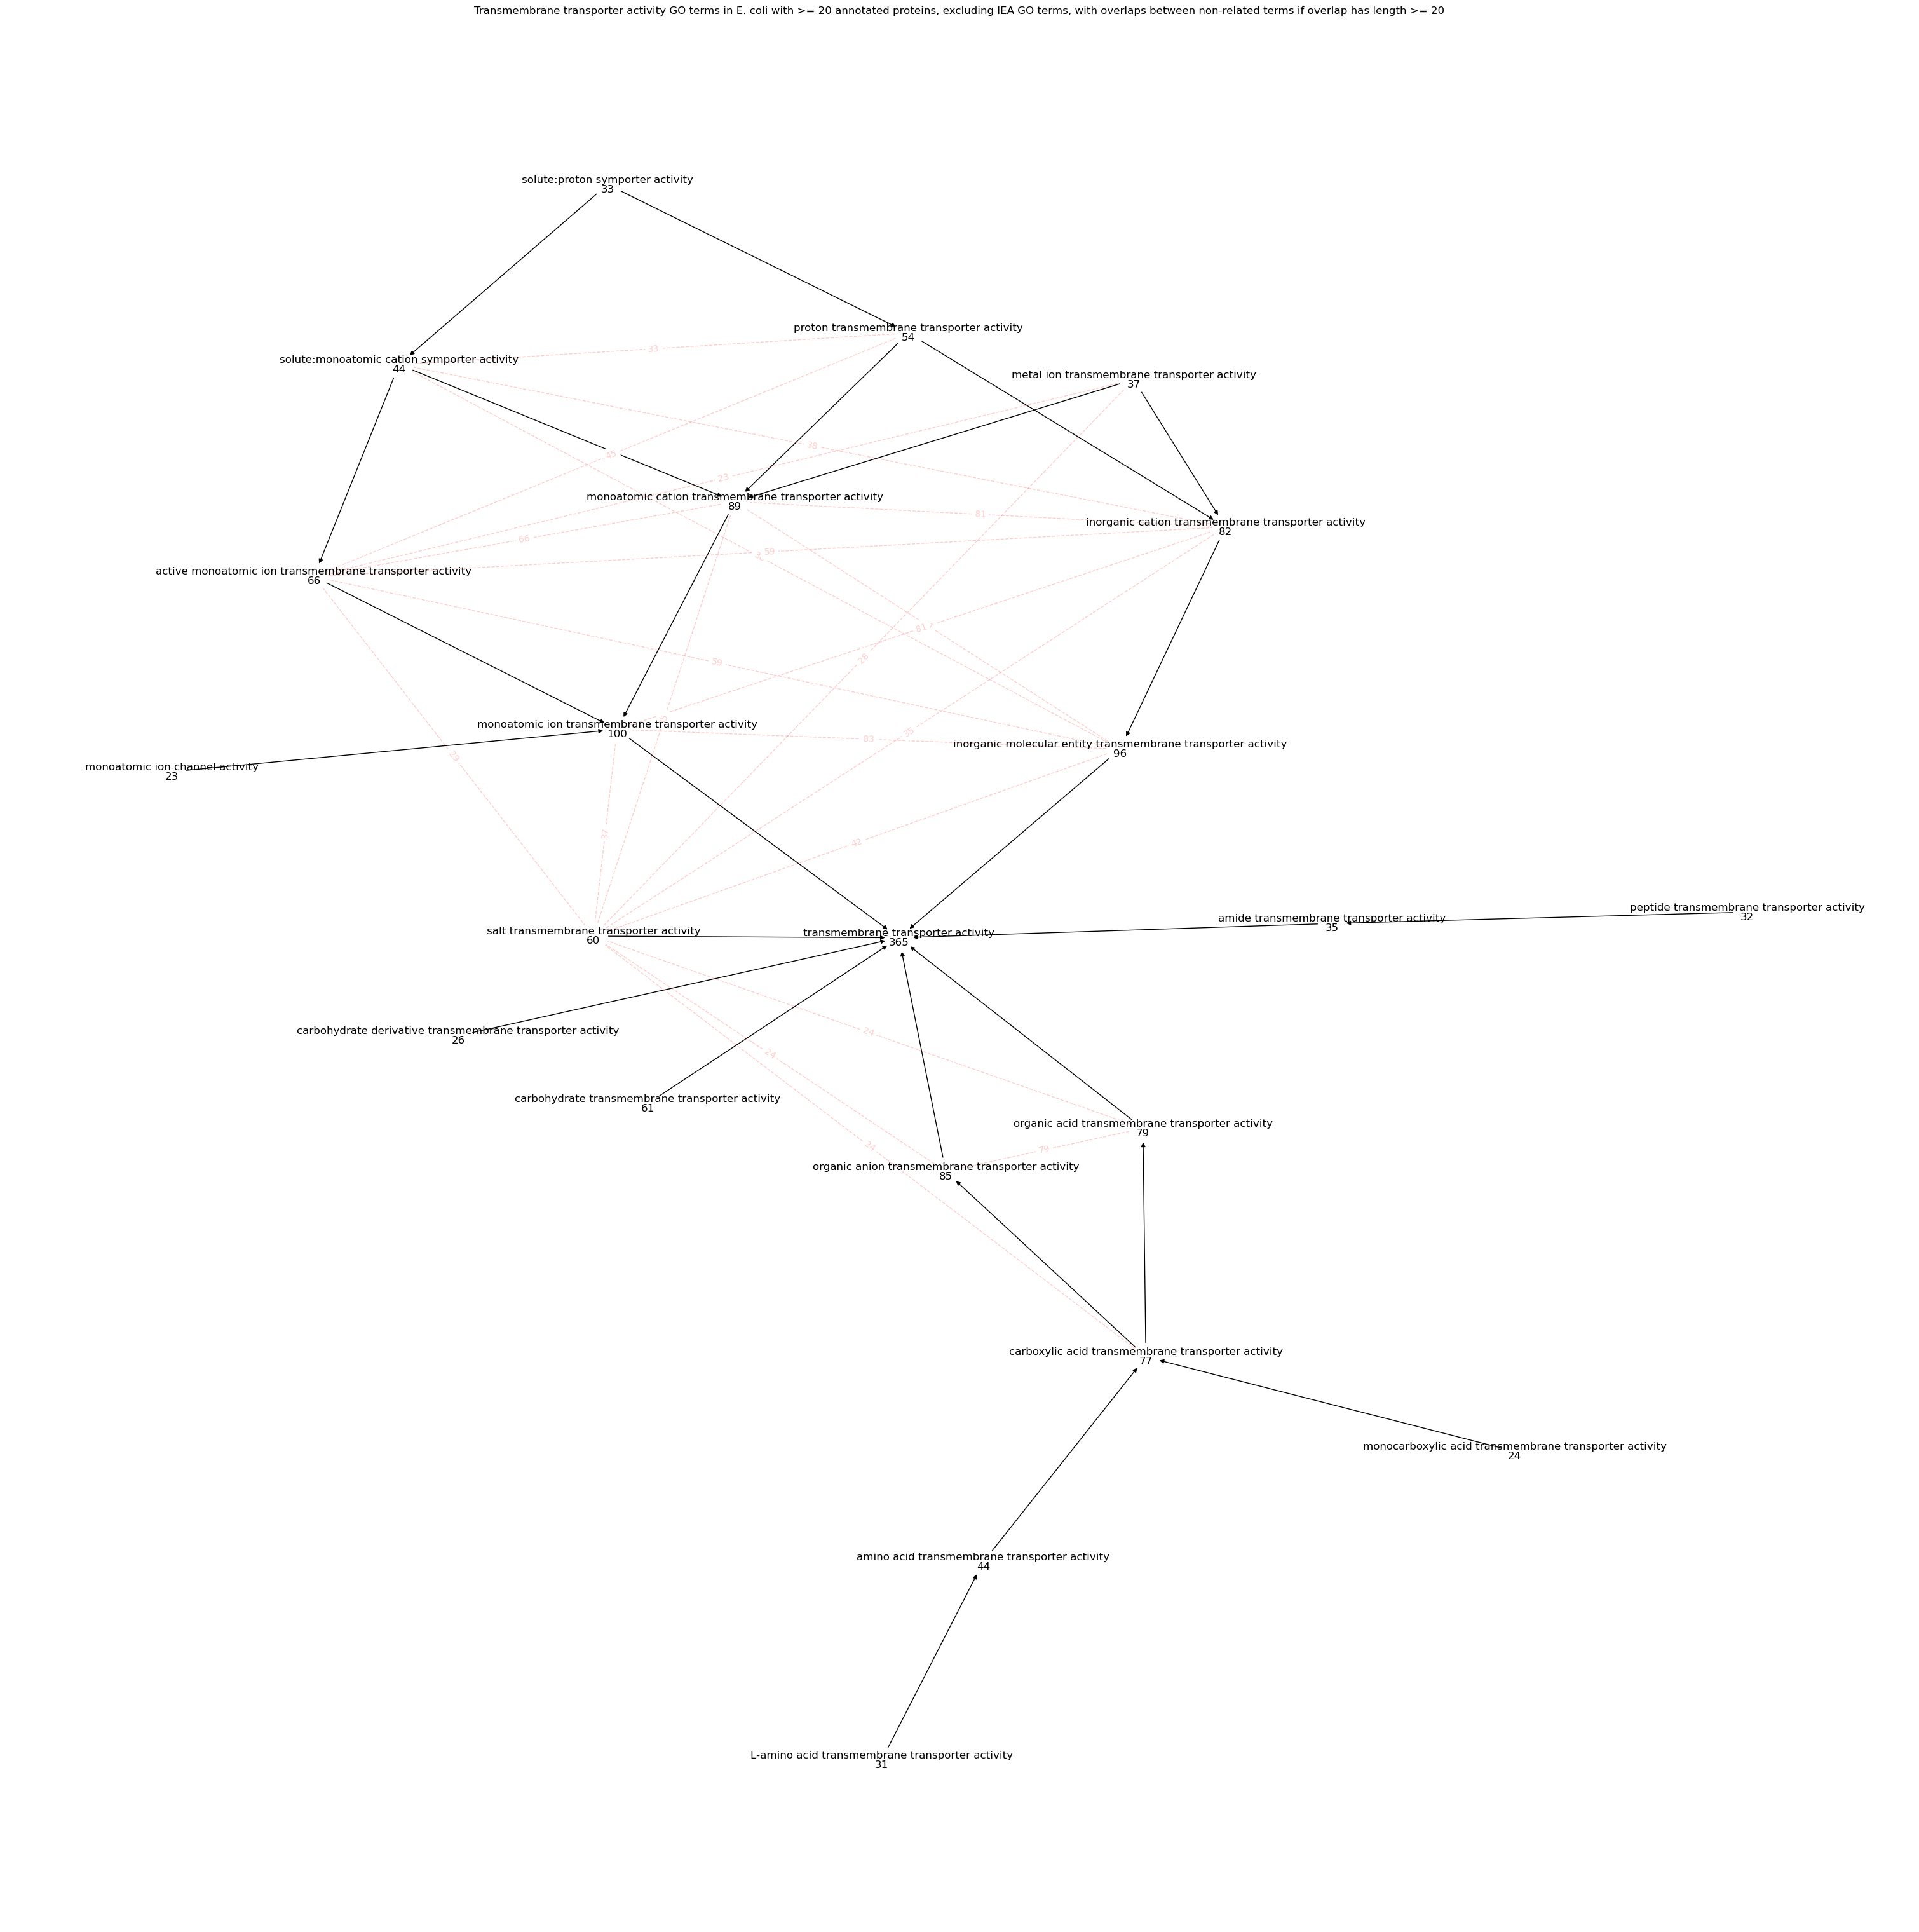

In [85]:
graph_plot(
    graph_to_plot=graph_go_mf_tmtp_ecoli.subgraph(
        {
            go_id
            for go_id, count in graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count_noiea")
            if count >= 20 and (go_id in go_to_chebi_primary_input.keys() or go_id == name_to_id["transmembrane transporter activity"])
        }
    ),
    label_name="name",
    label_count="ecoli_count_noiea",
    title="Transmembrane transporter activity GO terms in E. coli with >= 20 annotated proteins, \
excluding IEA GO terms, with overlaps between non-related terms if overlap has length >= 20, only go terms with chebi crossrelation",
    overlap_edges=edges_overlap_noiea,
    min_overlap=20,
    rotation=0,
    # progs: ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
    graphviz_layout="neato",
    node_size=1000
)


In [39]:
# TODO filter GO terms for those with associated chebi terms! 
# TODO chebi
# TODO is there a way to get chebi annotations of go terms? only keep go terms that have a substrate annotation!
# TODO filter Chebi by stars (3 stars only)